In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import glob as gb
import tensorflow as tf

In [3]:
size=94 #size of the image
train_dir='.\\Eye dataset'

train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.1,
).flow_from_directory(train_dir,batch_size=32,target_size=(size,size),subset="training",shuffle=True)

Found 10153 images belonging to 4 classes.


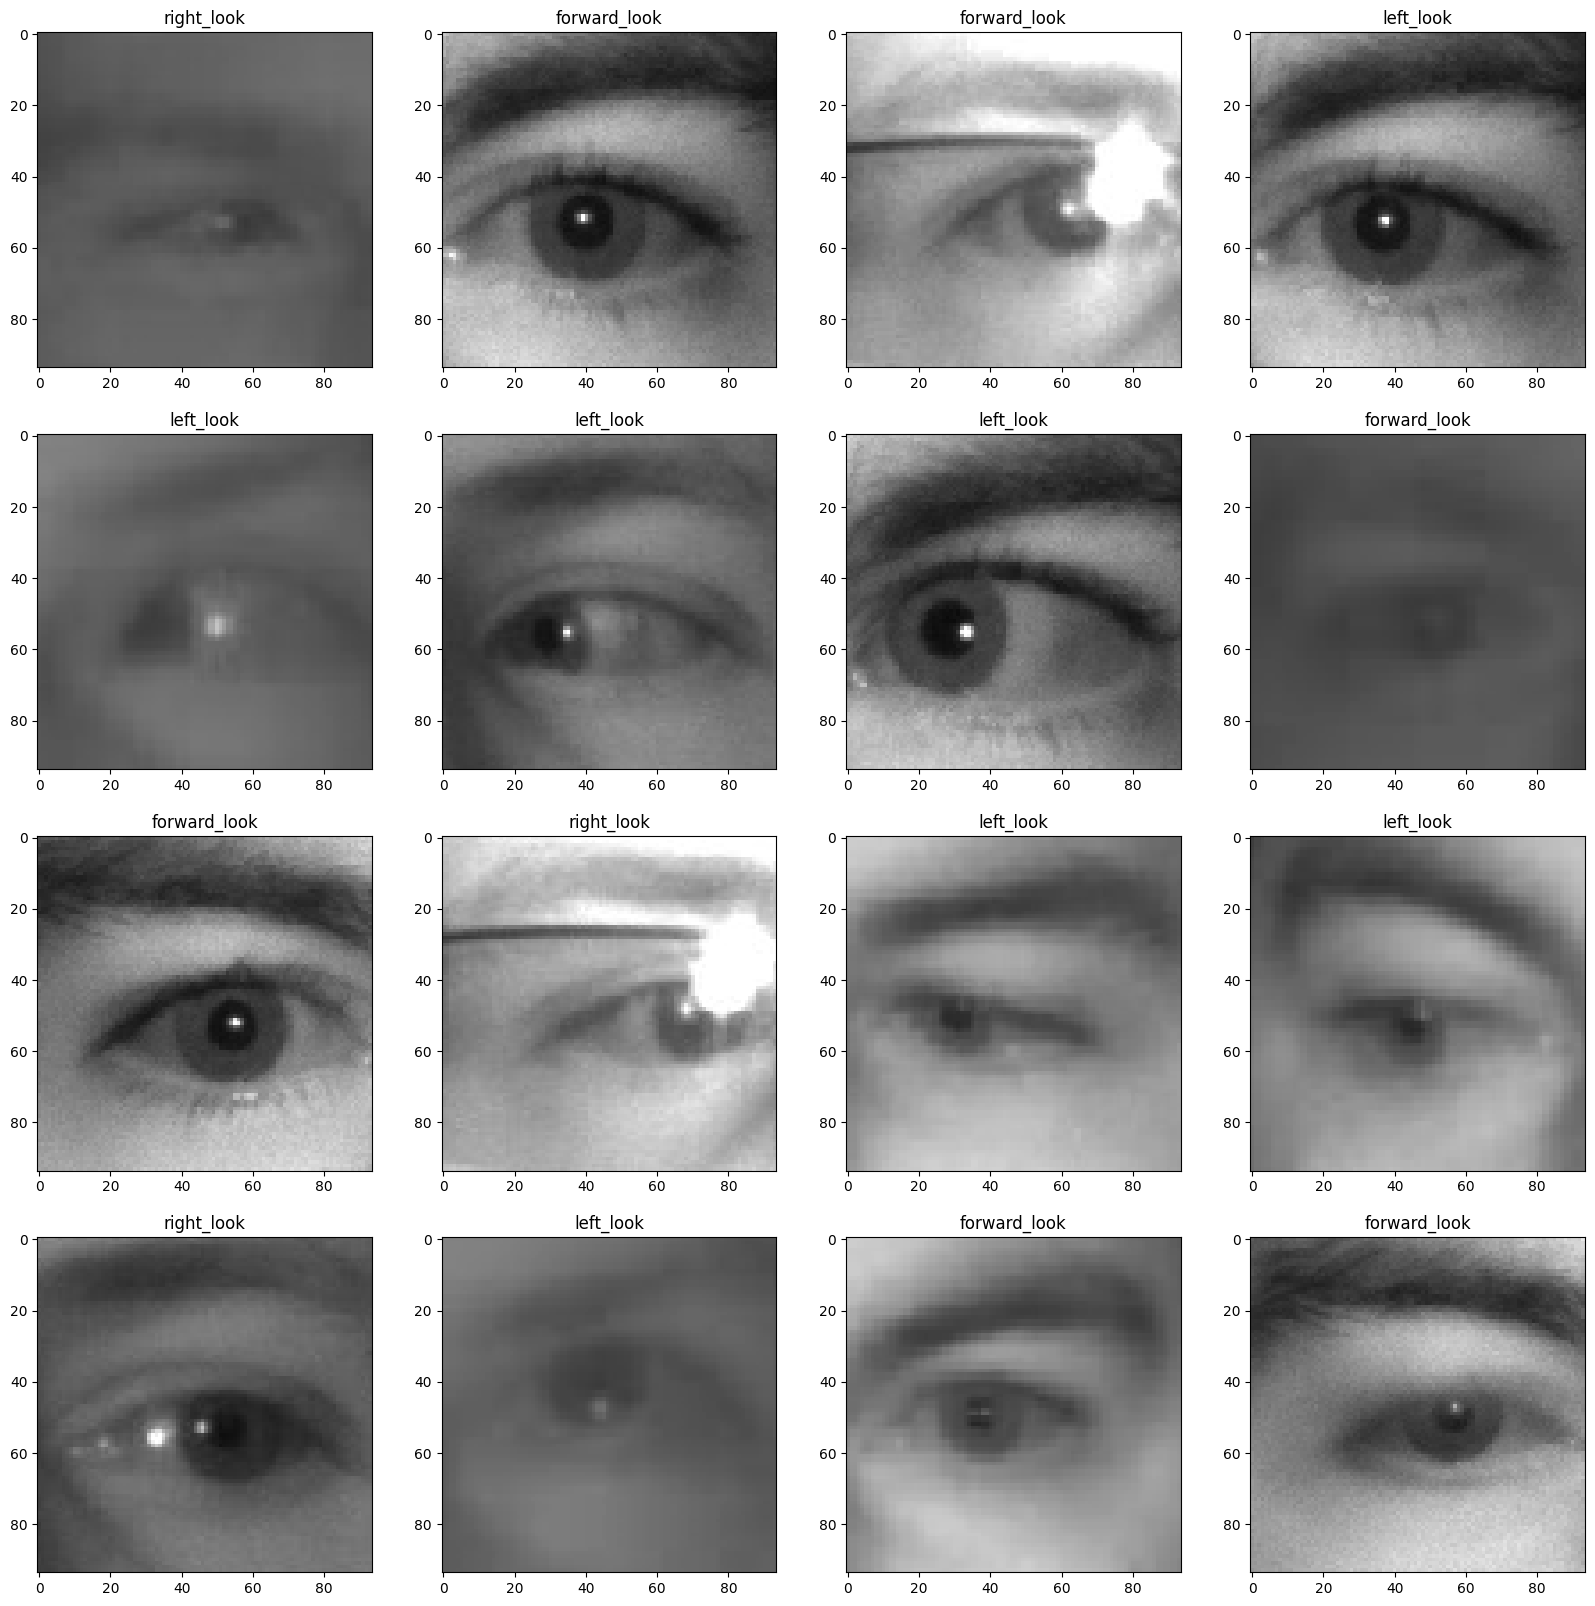

In [4]:
classes=list(train_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [5]:
valid_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2,
).flow_from_directory(train_dir,batch_size=32,target_size=(size,size),subset='validation',shuffle=True)

Found 2255 images belonging to 4 classes.


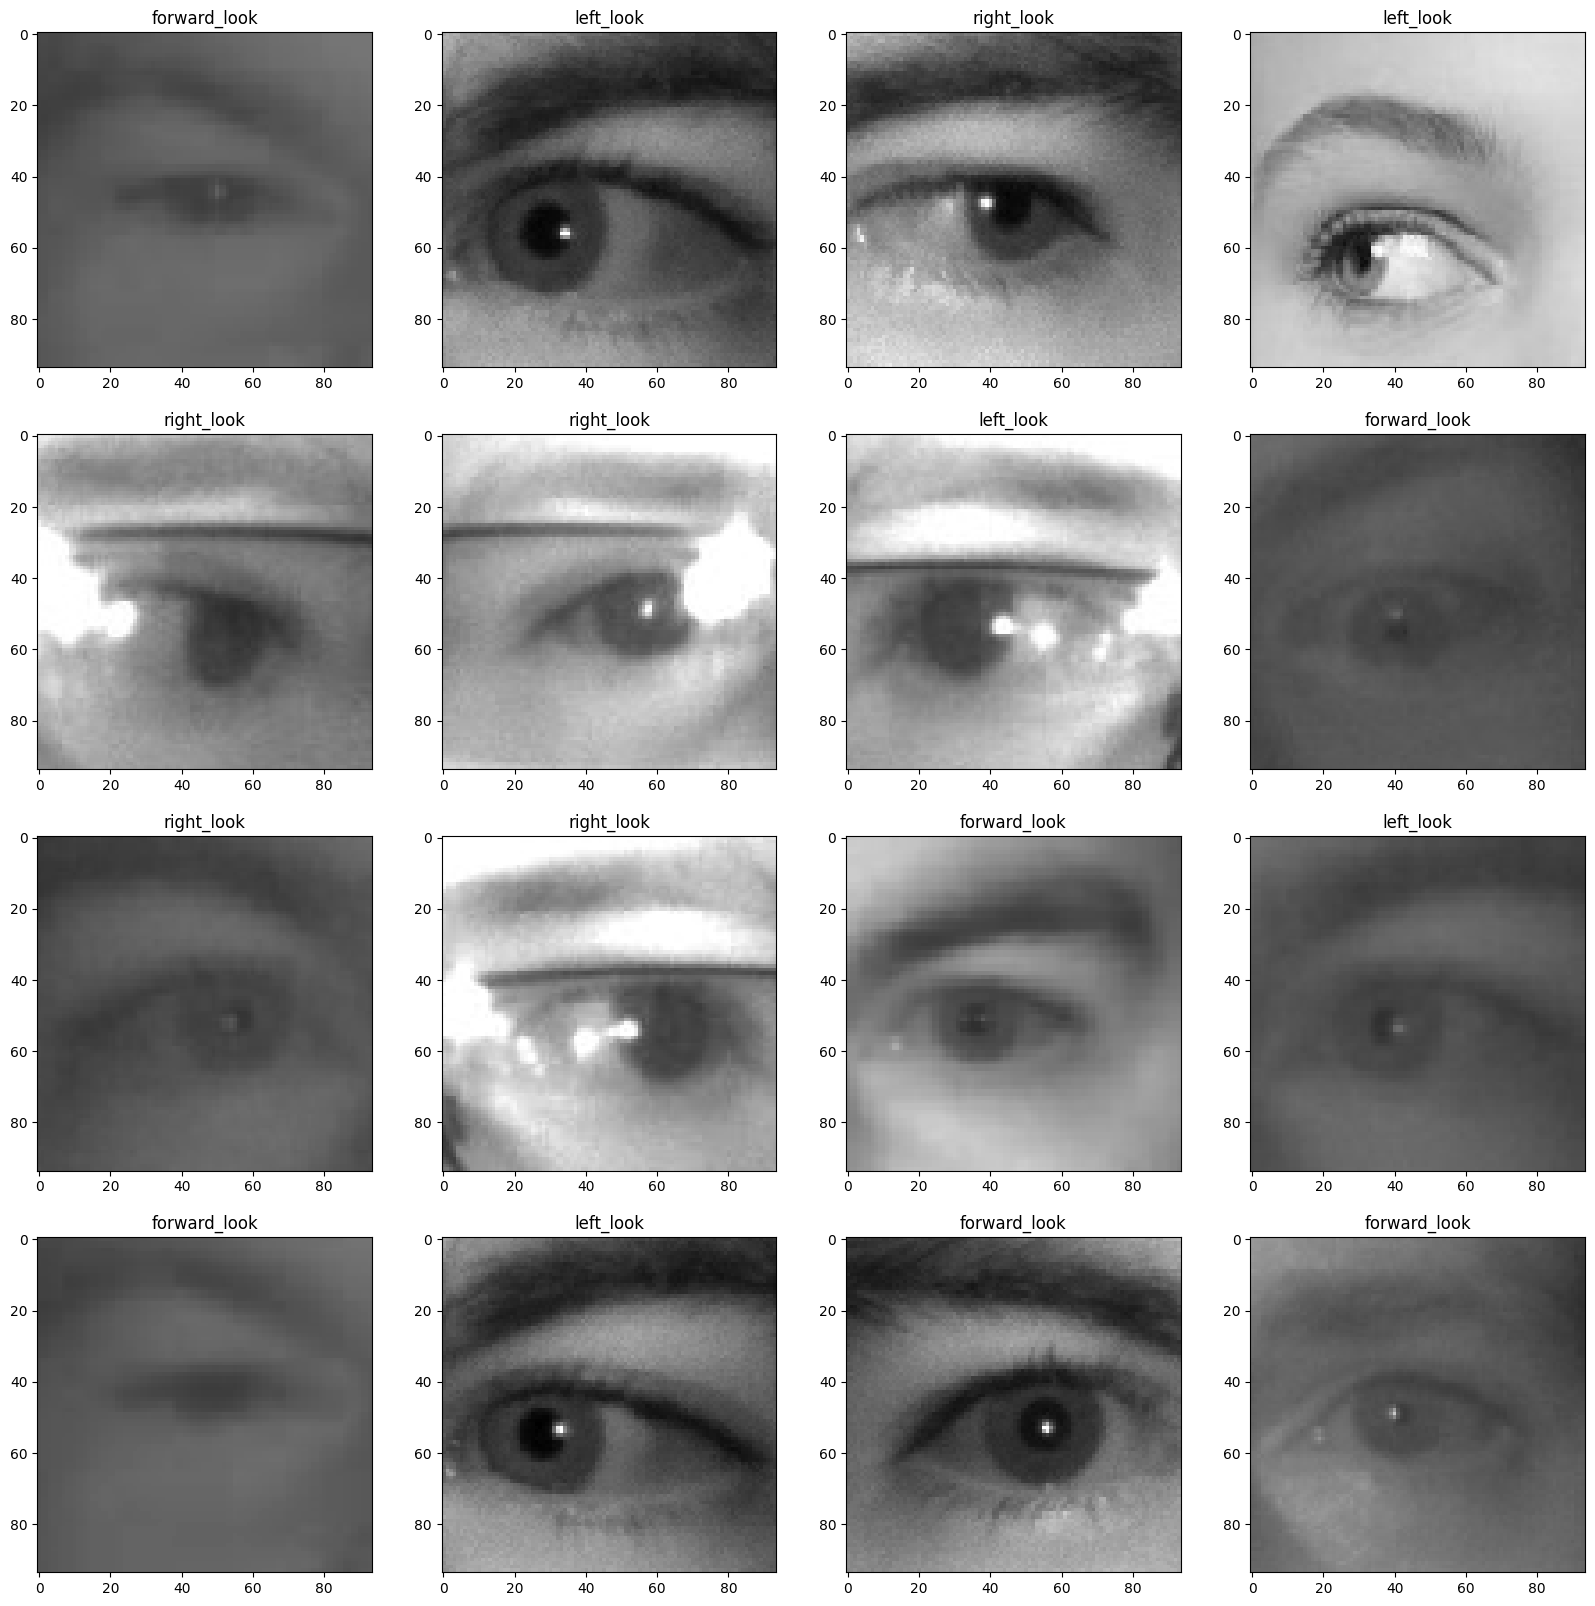

In [6]:
classes=list(valid_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in valid_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [7]:
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2
).flow_from_directory(train_dir,batch_size=32,target_size=(size,size),subset='validation',shuffle=True)


Found 2255 images belonging to 4 classes.


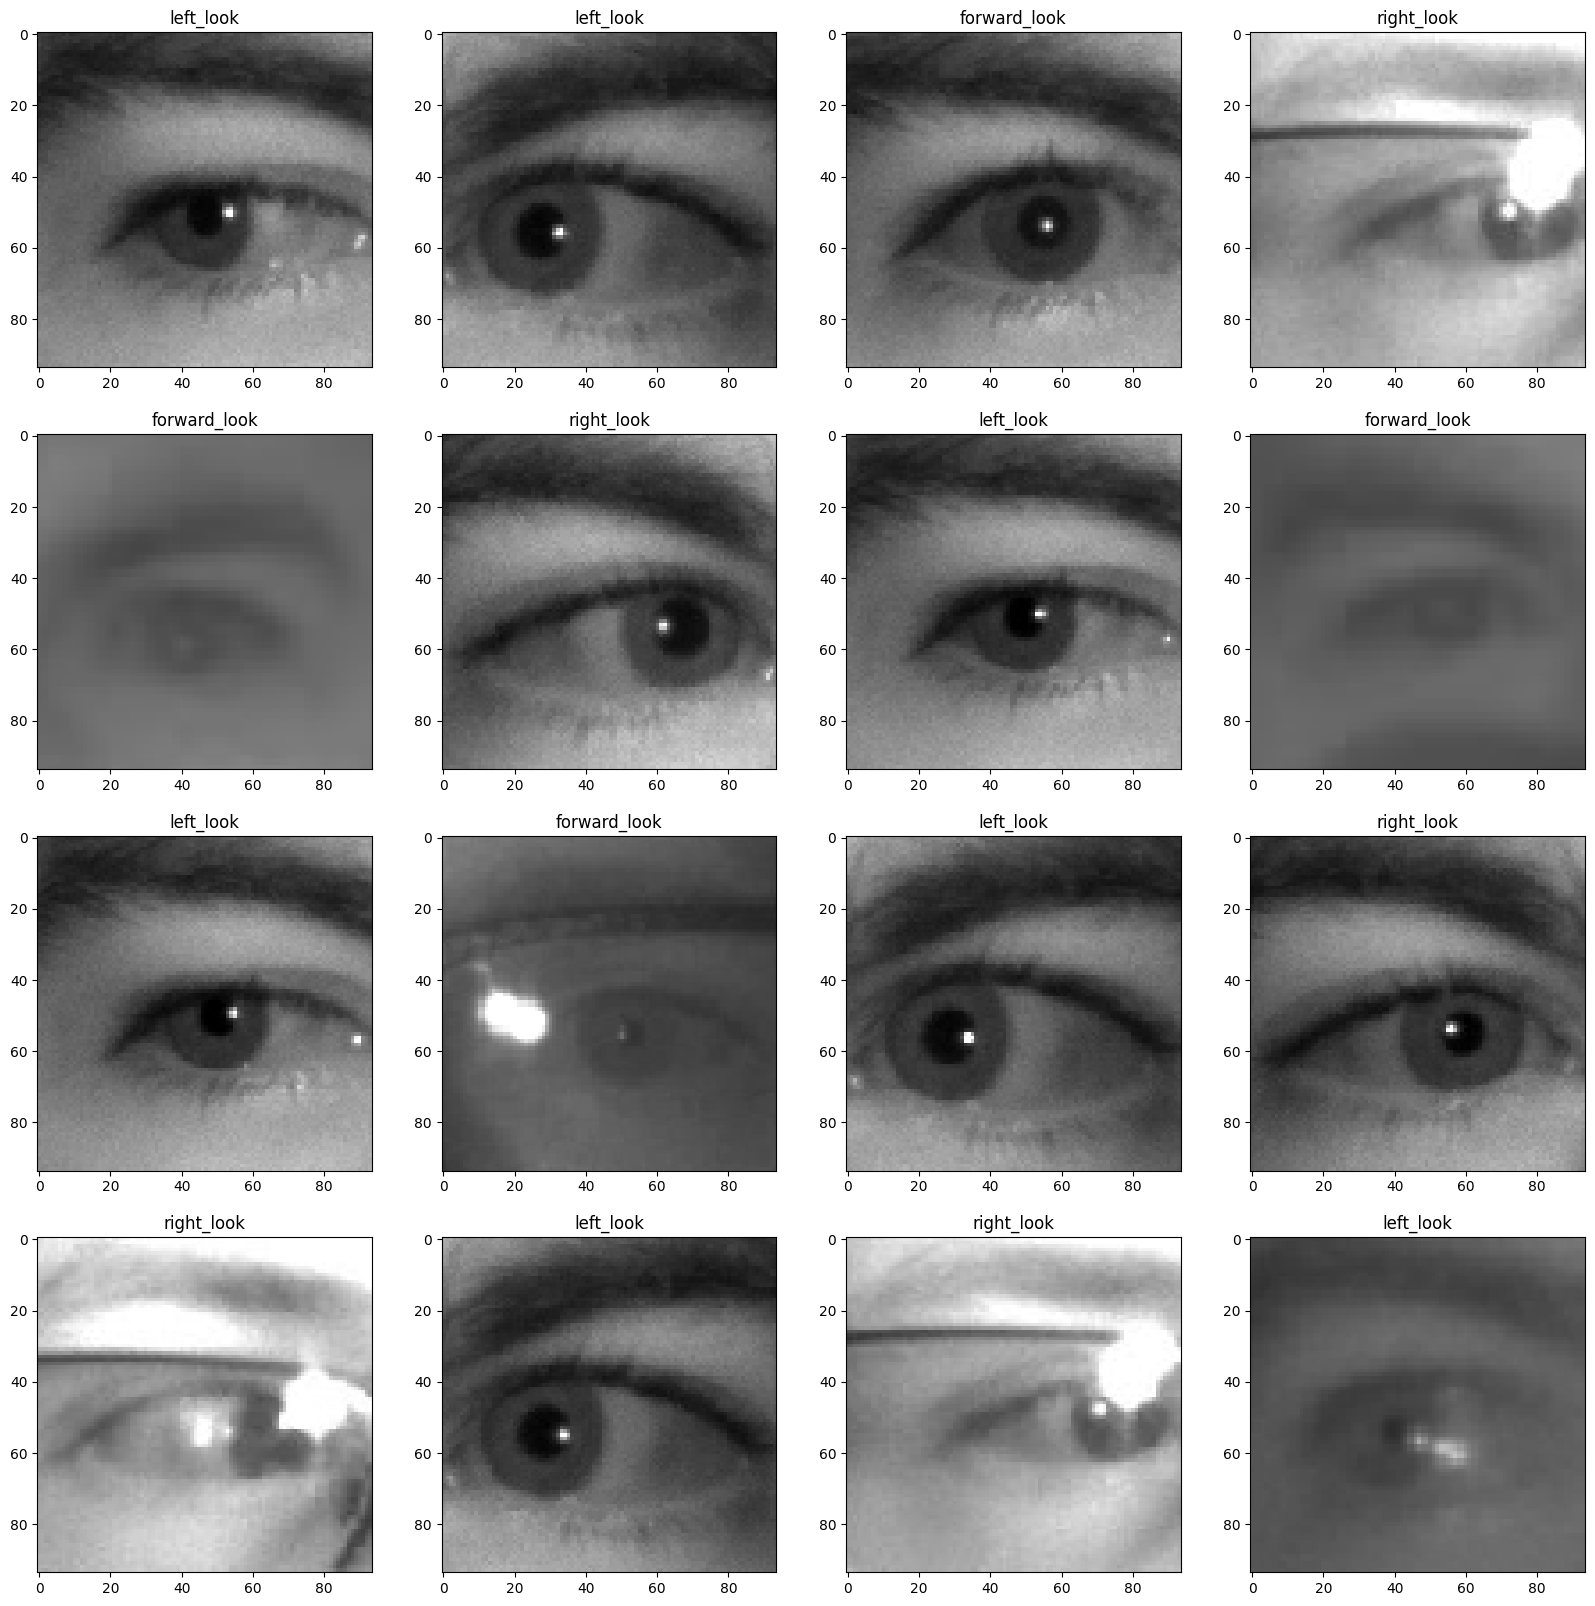

In [8]:
classes=list(test_generator.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in test_generator:
    # create a grid of 3x3 images
    for i in range(0,16):
        plt.subplot(4,4,i+1)
        plt.imshow(X_batch[i])
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    # show the plot
    plt.show()
    break

In [9]:
classes

['close_look', 'forward_look', 'left_look', 'right_look']

In [10]:
from keras.models import Sequential 
from keras.layers import Dense ,Flatten ,Conv2D ,MaxPooling2D ,Dropout ,BatchNormalization ,GlobalMaxPool2D
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

In [11]:
optimizer_adam=Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.99)

In [12]:
EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('model.keras',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [13]:
model = Sequential([
    Conv2D(32, 3, activation='relu',  kernel_initializer='he_normal', input_shape=(size, size, 3)),
    Conv2D(64, 3, activation='relu',  kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(3),

    Conv2D(128, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(3),

    Conv2D(256, 3, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D(3),

    Flatten(),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dense(4, activation='softmax', kernel_initializer='glorot_normal')
])


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 92, 92, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 90, 90, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 28, 28, 128)       5

In [15]:
model.compile(optimizer=optimizer_adam,loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
history=model.fit(train_generator,validation_data=valid_generator,epochs=50,batch_size=16,
                  steps_per_epoch=len(train_generator)//16,validation_steps=len(valid_generator)//16,
                  callbacks=callback, verbose=1)
model.save('model.keras')

Epoch 1/50


19/19 [==============================] - ETA: 0s - loss: 1.3604 - accuracy: 0.4309
Epoch 1: val_loss improved from inf to 1.31787, saving model to model.keras
19/19 [==============================] - 3s 111ms/step - loss: 1.3604 - accuracy: 0.4309 - val_loss: 1.3179 - val_accuracy: 0.4141 - lr: 1.0000e-04
Epoch 2/50
19/19 [==============================] - ETA: 0s - loss: 0.9174 - accuracy: 0.6678
Epoch 2: val_loss improved from 1.31787 to 1.24360, saving model to model.keras
19/19 [==============================] - 2s 103ms/step - loss: 0.9174 - accuracy: 0.6678 - val_loss: 1.2436 - val_accuracy: 0.4453 - lr: 1.0000e-04
Epoch 3/50
19/19 [==============================] - ETA: 0s - loss: 0.7103 - accuracy: 0.7599
Epoch 3: val_loss improved from 1.24360 to 1.21609, saving model to model.keras
19/19 [==============================] - 2s 101ms/step - loss: 0.7103 - accuracy: 0.7599 - val_loss: 1.2161 - val_accuracy: 0.4766 - lr: 1.0000e-04
Epoch 4/50
19/19 [==================

Model may be overfitting


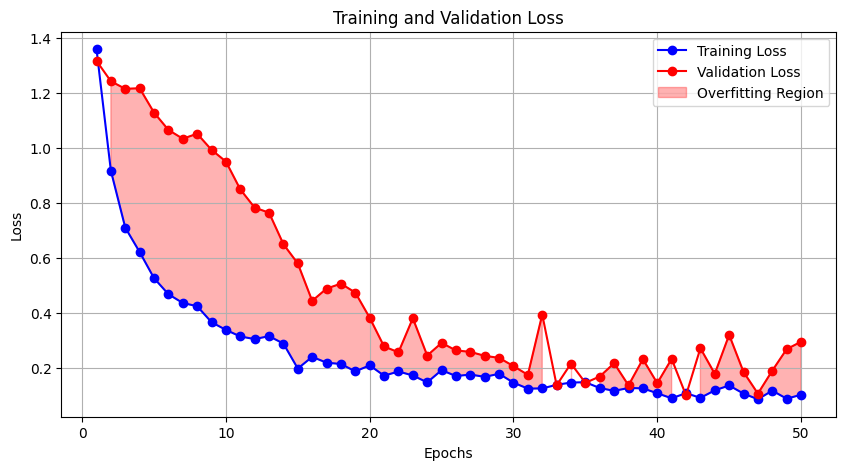

In [17]:
import matplotlib.pyplot as plt

def check_overfitting(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Check for overfitting
    if val_loss[-1] > train_loss[-1]:
        print("Model may be overfitting")
    else:
        print("Model is not overfitting")
    
    # Plotting
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(10, 5))
    
    # Plot train and validation loss
    plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    
    # Fill color segments for overfitting indication
    plt.fill_between(epochs, train_loss, val_loss, where=(np.array(val_loss) > np.array(train_loss)), 
                     color='red', alpha=0.3, label='Overfitting Region')
    
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


check_overfitting(history)

In [18]:
#plotting training values
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

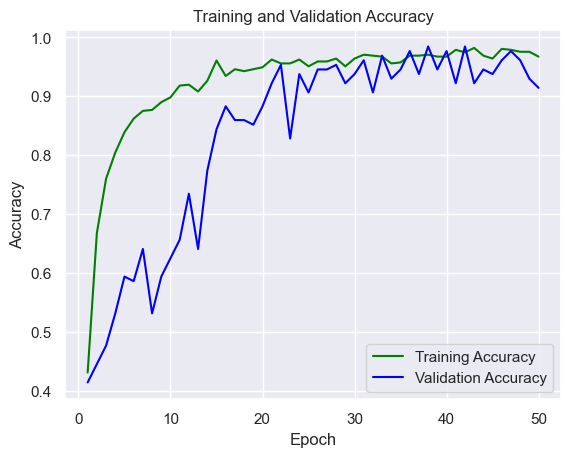

In [19]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

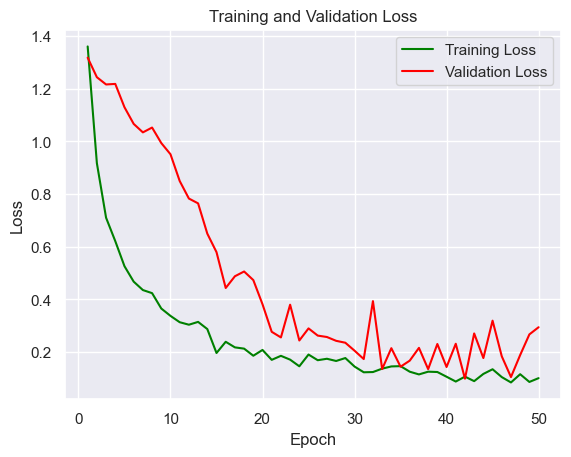

In [20]:
#loss plot
plt.plot(epochs, loss, color='green', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

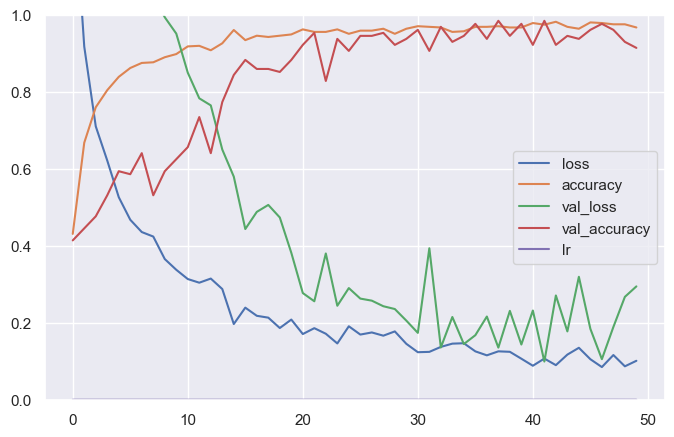

In [21]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

1/1 [==============================] - 0s 30ms/step


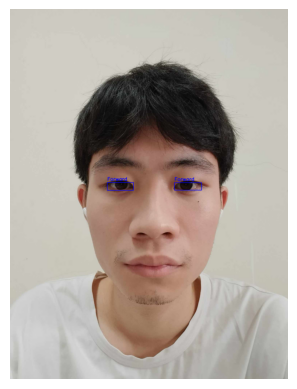

1/1 [==============================] - 0s 32ms/step


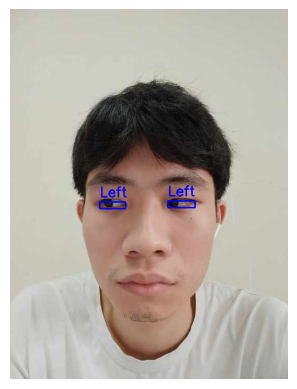

1/1 [==============================] - 0s 28ms/step


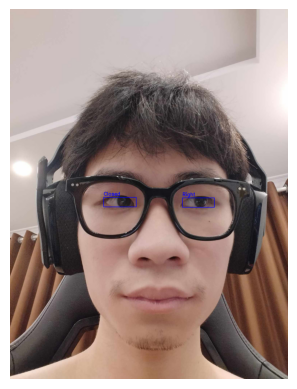

1/1 [==============================] - 0s 34ms/step


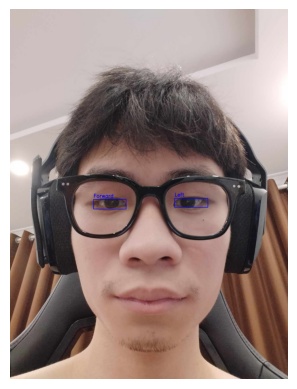

1/1 [==============================] - 0s 30ms/step


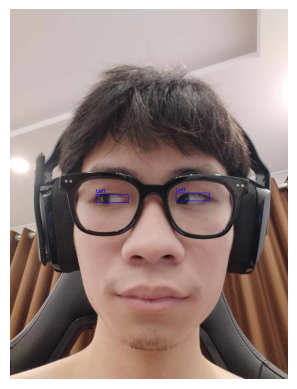

1/1 [==============================] - 0s 31ms/step


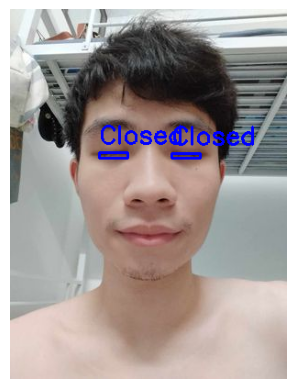

1/1 [==============================] - 0s 27ms/step


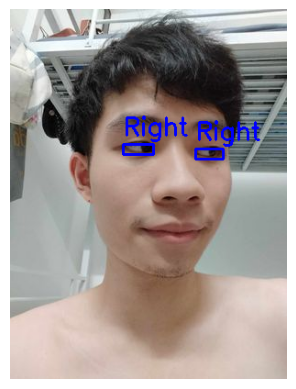

1/1 [==============================] - 0s 28ms/step


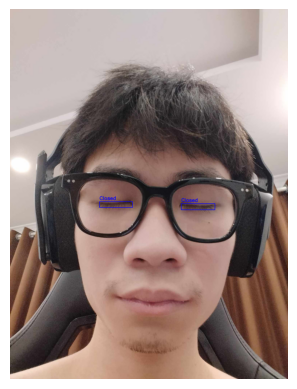

In [22]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

# Load trained CNN model
model_keras = load_model('model.keras')

# Initialize dlib's face detector (HOG-based) and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Function to detect facial landmarks and extract eye regions
def detect_eyes_dlib(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)
    eyes = []
    for face in faces:
        landmarks = predictor(gray, face)
        # Extracting the coordinates for the left eye
        left_eye_pts = np.array([(landmarks.part(36).x, landmarks.part(36).y),
                                 (landmarks.part(37).x, landmarks.part(37).y),
                                 (landmarks.part(38).x, landmarks.part(38).y),
                                 (landmarks.part(39).x, landmarks.part(39).y),
                                 (landmarks.part(40).x, landmarks.part(40).y),
                                 (landmarks.part(41).x, landmarks.part(41).y)], np.int32)
        # Extracting the coordinates for the right eye
        right_eye_pts = np.array([(landmarks.part(42).x, landmarks.part(42).y),
                                  (landmarks.part(43).x, landmarks.part(43).y),
                                  (landmarks.part(44).x, landmarks.part(44).y),
                                  (landmarks.part(45).x, landmarks.part(45).y),
                                  (landmarks.part(46).x, landmarks.part(46).y),
                                  (landmarks.part(47).x, landmarks.part(47).y)], np.int32)
        eyes.append(left_eye_pts)
        eyes.append(right_eye_pts)
    return eyes

# Function to preprocess the eye region for prediction
def preprocess_eye(eye_region):
    eye_region = cv2.resize(eye_region, (94, 94))  # Resize to the input size of the model
    eye_region = eye_region.astype('float64') / 255.0
    eye_region = np.expand_dims(eye_region, axis=0)
    return eye_region

# Function to predict the state of the eye
def predict_eye_state(eye_region):
    processed_eye = preprocess_eye(eye_region)
    prediction = model_keras.predict(processed_eye)
    return np.argmax(prediction, axis=1)[0]

# Function to process an input image and display using matplotlib
def process_image(image_path):
    image = cv2.imread(image_path)
    eyes = detect_eyes_dlib(image)
    
    labels = {0: 'Closed', 1: 'Forward', 2: 'Left', 3: 'Right'}
    
    for eye_pts in eyes:
        # Get the bounding box of the eye region
        x, y, w, h = cv2.boundingRect(eye_pts)
        eye_region = image[y:y+h, x:x+w]
        state = predict_eye_state(eye_region)
        label = labels[state]
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Test the function with an example image
image_paths = [
    ".\\test image\\test.jpg",
    ".\\test image\\left.jpg",
    ".\\test image\\glasses_right.jpg",
    ".\\test image\\glasses_fw.jpg",
    ".\\test image\\glasses_left.jpg",
    ".\\test image\\closed.jpg",
    ".\\test image\\right.jpg",
    ".\\test image\\glasses_closed.jpg"
]

for image_path in image_paths:
    process_image(image_path)


1/1 [==============================] - 0s 17ms/step


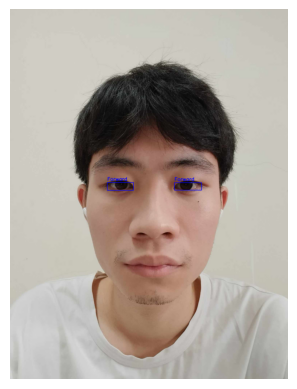

1/1 [==============================] - 0s 17ms/step


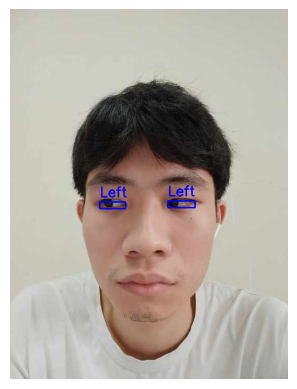

1/1 [==============================] - 0s 18ms/step


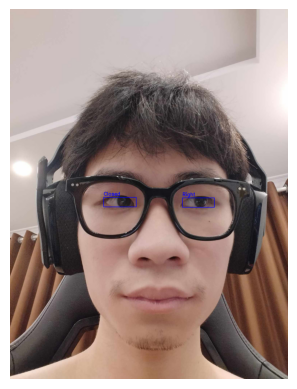

1/1 [==============================] - 0s 18ms/step


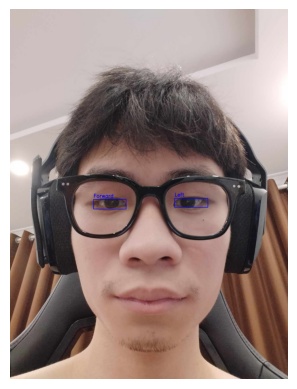

1/1 [==============================] - 0s 17ms/step


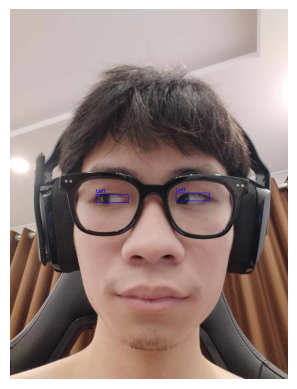

1/1 [==============================] - 0s 18ms/step


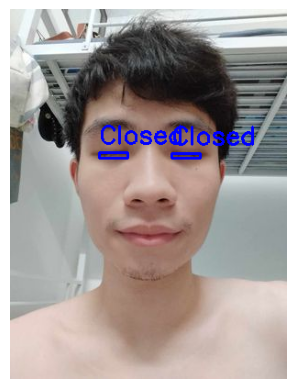

1/1 [==============================] - 0s 18ms/step


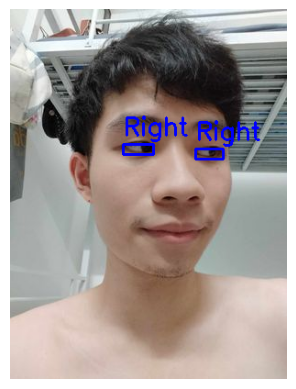

1/1 [==============================] - 0s 19ms/step


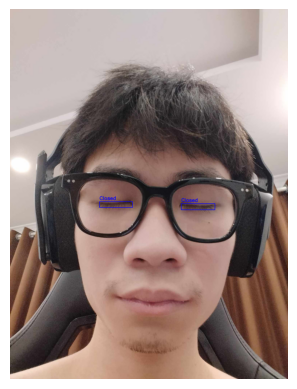

Accuracy: 0.88
Classification Report:
              precision    recall  f1-score   support

      Closed       0.80      1.00      0.89         4
     Forward       1.00      0.75      0.86         4
        Left       0.80      1.00      0.89         4
       Right       1.00      0.75      0.86         4

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [24]:
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report

# Load trained CNN model
model_keras = load_model('model.keras')

# Initialize dlib's face detector (HOG-based) and facial landmarks predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Function to detect facial landmarks and extract eye regions
def detect_eyes_dlib(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)
    eyes = []
    for face in faces:
        landmarks = predictor(gray, face)
        # Extracting the coordinates for the left eye
        left_eye_pts = np.array([(landmarks.part(36).x, landmarks.part(36).y),
                                 (landmarks.part(37).x, landmarks.part(37).y),
                                 (landmarks.part(38).x, landmarks.part(38).y),
                                 (landmarks.part(39).x, landmarks.part(39).y),
                                 (landmarks.part(40).x, landmarks.part(40).y),
                                 (landmarks.part(41).x, landmarks.part(41).y)], np.int32)
        # Extracting the coordinates for the right eye
        right_eye_pts = np.array([(landmarks.part(42).x, landmarks.part(42).y),
                                  (landmarks.part(43).x, landmarks.part(43).y),
                                  (landmarks.part(44).x, landmarks.part(44).y),
                                  (landmarks.part(45).x, landmarks.part(45).y),
                                  (landmarks.part(46).x, landmarks.part(46).y),
                                  (landmarks.part(47).x, landmarks.part(47).y)], np.int32)
        eyes.append(left_eye_pts)
        eyes.append(right_eye_pts)
    return eyes

# Function to preprocess the eye region for prediction
def preprocess_eye(eye_region):
    eye_region = cv2.resize(eye_region, (94, 94))  # Resize to the input size of the model
    eye_region = eye_region.astype('float64') / 255.0
    eye_region = np.expand_dims(eye_region, axis=0)
    return eye_region

# Function to predict the state of the eye
def predict_eye_state(eye_region):
    processed_eye = preprocess_eye(eye_region)
    prediction = model_keras.predict(processed_eye)
    return np.argmax(prediction, axis=1)[0]

# Function to process an input image and display using matplotlib
def process_image(image_path, true_label):
    image = cv2.imread(image_path)
    eyes = detect_eyes_dlib(image)
    
    labels = {0: 'Closed', 1: 'Forward', 2: 'Left', 3: 'Right'}
    
    predictions = []
    true_labels = []
    
    for eye_pts in eyes:
        # Get the bounding box of the eye region
        x, y, w, h = cv2.boundingRect(eye_pts)
        eye_region = image[y:y+h, x:x+w]
        state = predict_eye_state(eye_region)
        label = labels[state]
        predictions.append(state)
        true_labels.append(true_label)
        cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    # Convert BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
    
    return predictions, true_labels

# Test the function with an example image
image_paths = [
    (".\\test image\\test.jpg", 1),  # 'Forward'
    (".\\test image\\left.jpg", 2),  # 'Left'
    (".\\test image\\glasses_right.jpg", 3),  # 'Right'
    (".\\test image\\glasses_fw.jpg", 1),  # 'Forward'
    (".\\test image\\glasses_left.jpg", 2),  # 'Left'
    (".\\test image\\closed.jpg", 0),  # 'Closed'
    (".\\test image\\right.jpg", 3),  # 'Right'
    (".\\test image\\glasses_closed.jpg", 0)  # 'Closed'
]

all_predictions = []
all_true_labels = []

for image_path, true_label in image_paths:
    predictions, true_labels = process_image(image_path, true_label)
    all_predictions.extend(predictions)
    all_true_labels.extend(true_labels)

# Calculate and print accuracy and classification report
accuracy = accuracy_score(all_true_labels, all_predictions)
report = classification_report(all_true_labels, all_predictions, target_names=['Closed', 'Forward', 'Left', 'Right'])

print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(report)
